# Gaussian mixture model for halo properties

In this notebook I will take an example set of halo properties and attempt to fit a Gaussian mixture model (GMM) to them. I will vary the number of components (Gaussians) and maximize the held-out likelihood of a test set of halos in order to find the optimal number of components to use.

In [16]:
import ConditionalGMM
import itertools
import numpy as np
from scipy import linalg
from sklearn import mixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
#Read in the halo catalog
from catalog import *
#Select a simulation
length       = 2000 #Mpc/h comoving
scale_factor = 1.
#Create the Catalog object
cat = Catalog([length], scale_factor)
print(len(cat.property("Spin")))
cat.add_property("lnSpin", np.log(cat.property("Spin")))
cat.add_property("lnSpin", np.log(cat.property("Spin")))

7950


In [3]:
#Format for the plots
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [4]:
#Colors to iterate over -- we will have a max of 5 components for now
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

In [5]:
#Define a function to plot the Gaussian 1sigma ellipses generated by a mixture model
def plot_results(X, Y_, means, covariances, index, labels, title=None):
    """
    Note: X must be [N_points x 2].
    
    Args:
        X (array): 2D array with points and the two dimensions we are plotting them in
        Y (array): 1D array of the labels of the points
        means (array): 1D array of means of the underlying Gaussians
        covariance (array): list of 2D arrays (i.e. a 3D array) that represent the covariance matrices of the Gaussians
        index (int): which subplot we are plotting on
        title (string): title for the subplot
        labels (list): axis labels
        
    Returns:
        None
    """
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            print("Skipped component %d"%i)
            continue
        print("N in %d = %d"%(i, len(X[Y_==i])))
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
#    plt.xticks(())
#    plt.yticks(())
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    if title is not None:
        plt.title(title)
    return

In [6]:
#Create an array with the properties we are looking at for now
X = np.array([np.log(cat.property("X_Rsp_mean")), cat.property("lnSpin")]).T#, cat.property("nusp_mean")]).T
labels = [r"$\ln(X_{R,{\rm mean}})$", r"$\ln({\rm Spin})$"]#, r"$\nu_{\rm mean}$"]
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)

(5326, 2) (2624, 2)


N in 0 = 2624
0.5047368432668777


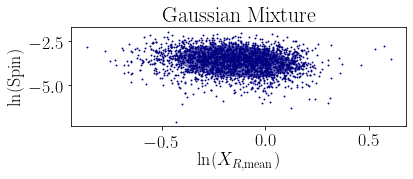

In [7]:
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full').fit(X_train)
plot_results(X_test, gmm.predict(X_test), gmm.means_, gmm.covariances_, 0, labels,
             'Gaussian Mixture')
print(np.exp(gmm.score(X_test)))

[-1794.07626283 -1755.06185801 -1757.16138271 -1758.06625567
 -1765.82927422 -1762.11695068 -1764.17086725 -1756.6434322
 -1751.30864171 -1749.36897611]


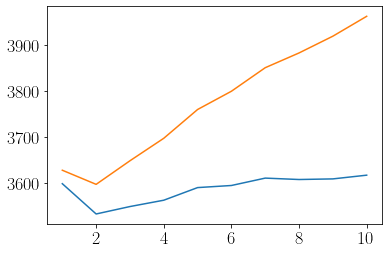

In [8]:
n_components = np.arange(1, 10+1)
scores = np.zeros_like(n_components, dtype="float")
BIC = np.zeros_like(scores)
AIC = np.zeros_like(scores)
for i, n in enumerate(n_components):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(X_train)
    scores[i] = gmm.score_samples(X_test).sum()
    BIC[i] = gmm.bic(X_test)#np.log(len(X_test))*n - 2*gmm.score_samples(X_test).sum()
    AIC[i] = gmm.aic(X_test)
print(scores)
plt.plot(n_components, AIC)
plt.plot(n_components, BIC)

In [10]:
#2 gaussians (components) is optimal
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X_train)

In [14]:
weights = gmm.weights_
means = gmm.means_
covs = gmm.covariances_
print(weights.shape, means.shape, covs.shape)
print(means[0])

(2,) (2, 2) (2, 2, 2)
[-0.16911809 -3.36761837]


In [18]:
#Create a conditional GMM, where we will fix lnSpin to learn about ln(X_R)
cGMM = ConditionalGMM.CondGMM(weights, means, covs, fixed_indices=[1])

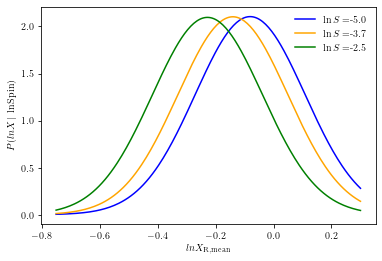

In [25]:
colors = ["blue", "orange", "green"]

lnS_obs = np.array([-5, -3.7, -2.5])
lnXR = np.linspace(-0.75, 0.3, 200)
for i, lnS in enumerate(lnS_obs):
    lnXR_cpdf = np.array([cGMM.conditional_pdf([yi], lnS) for yi in lnXR])
    plt.plot(lnXR, lnXR_cpdf, label=r"$\ln S=${x}".format(x=lnS), color=colors[i])
plt.xlabel(r"$ln X_{\rm R,mean}$")
plt.ylabel(r"$P(ln X\,|\,\ln {\rm Spin})$")
plt.legend(frameon=False)